# Customer churn prediction

### Dataset:

- customerID - customer id

- gender - client gender (male / female)

- SeniorCitizen - is the client retired (1, 0)

- Partner - is the client married (Yes, No)

- tenure - how many months a person has been a client of the company

- PhoneService - is the telephone service connected (Yes, No)

- MultipleLines - are multiple phone lines connected (Yes, No, No phone service)

- InternetService - client’s Internet service provider (DSL, Fiber optic, No)

- OnlineSecurity - is the online security service connected (Yes, No, No internet service)

- OnlineBackup - is the online backup service activated (Yes, No, No internet service)

- DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)

- TechSupport - is the technical support service connected (Yes, No, No internet service)

- StreamingTV - is the streaming TV service connected (Yes, No, No internet service)

- StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)

- Contract - type of customer contract (Month-to-month, One year, Two year)

- PaperlessBilling - whether the client uses paperless billing (Yes, No)

- PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

- MonthlyCharges - current monthly payment

- TotalCharges - the total amount that the client paid for the services for the entire time

- Churn - whether there was a churn (Yes or No)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

## to split data
from sklearn.model_selection import train_test_split

## data cleaning and processing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## for classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

## for ensemble classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier

## to get metrics of model performance
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

## for hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 7.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491664 sha256=e0b20c522ff56fd9814f556ecc2a18d2181ef2c4db2ea8e0587da6c902256bd4
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
import shap

### Load data

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

data_path="/gdrive/MyDrive"
df = pd.read_csv(f'{data_path}/telecom_users.csv',na_values = '#NAME?')

Mounted at /gdrive


## Data exploration and cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


#### changing the total charge column into a numerical variable and dealing with missing values

In [ ]:
df['TotalCharges'].unique()
df['TotalCharges'][356]

' '

In [ ]:
# Replace spaces with nan in the TotalCarges column
df["TotalCharges"] = df["TotalCharges"].replace(r' ', np.nan, regex=True)

In [ ]:
df['TotalCharges'].head()
df['TotalCharges'].unique()

array(['1734.65', '3973.2', '2869.85', ..., '306.05', '1200.15', '457.3'],
      dtype=object)

In [ ]:
df['TotalCharges'][356]

nan

In [ ]:
df['TotalCharges'] = df['TotalCharges'].astype("float")

In [ ]:
df['TotalCharges'][np.isnan(df['TotalCharges'])]

356    NaN
634    NaN
2771   NaN
3086   NaN
3255   NaN
4326   NaN
5375   NaN
5382   NaN
5695   NaN
5951   NaN
Name: TotalCharges, dtype: float64

#### changing the senior citizen column into a categorical variable

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x: "S" if x == 1 else "Y")

In [ ]:
df['SeniorCitizen'].value_counts()

Y    5020
S     966
Name: SeniorCitizen, dtype: int64

In [ ]:
pd.DataFrame(df.apply(lambda x: sum(x.isna()/len(df)))).sort_values(by=0, ascending=False)

,0
TotalCharges,0.001671
Unnamed: 0,0.000000
customerID,0.000000
MonthlyCharges,0.000000
PaymentMethod,0.000000
PaperlessBilling,0.000000
Contract,0.000000
StreamingMovies,0.000000
StreamingTV,0.000000
TechSupport,0.000000


In [ ]:
print("Total number of duplicated rows:", len(df[df.duplicated()]))

Total number of duplicated rows: 0


In [ ]:
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,Y,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,Y,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,6344,9286-DOJGF,Female,S,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,Y,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,432,2181-UAESM,Male,Y,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


#### droping some irrelevant columns

In [ ]:
df = df.drop(columns = ["Unnamed: 0", "customerID"])
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,Y,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,Y,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,Female,S,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,Y,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,Male,Y,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


#### The correlation between tenure and monthly charges

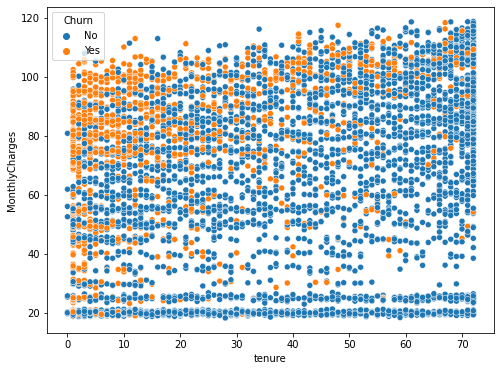

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.scatterplot(x = 'tenure', y = 'MonthlyCharges', hue = 'Churn', data = df);

#### The correlation between tenure and total charges

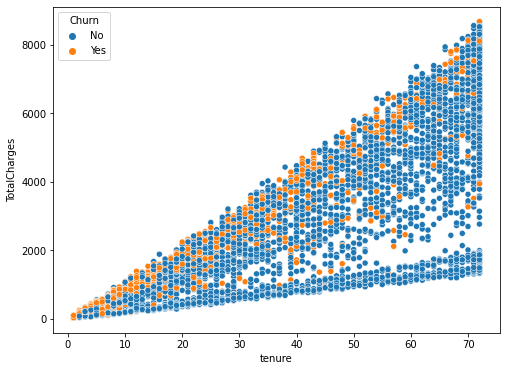

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.scatterplot(x = 'tenure', y = 'TotalCharges', hue = 'Churn', data = df);

From those 2 graphs, it seems clear that there are 2 categories of customers when it comes to the amount paid for the service. 

Some customers seem to have subscribed to a basic service and pay a consistent price per month (actually there seems to be 2 basic services types, one costing 20 dollars/month, the other one costing 25 dollars/months).

Other customers seem to have subscribed to the basic services plus some extr options, possibly including streaming services, online security etc...

It looks like very few customers churn when subscribing to the basic services. It might therefore be worth it concentrating analyses on customers having siubscribed to extra options.

In [ ]:
df['subscription'] = df['MonthlyCharges'].apply(lambda x: "extra" if x > 27 else "basic")
df['subscription'].head(30)

0     basic
1     extra
2     extra
3     extra
4     extra
5     extra
6     extra
7     basic
8     extra
9     extra
10    extra
11    extra
12    extra
13    extra
14    extra
15    extra
16    extra
17    basic
18    extra
19    extra
20    basic
21    extra
22    basic
23    extra
24    extra
25    extra
26    extra
27    basic
28    extra
29    extra
Name: subscription, dtype: object

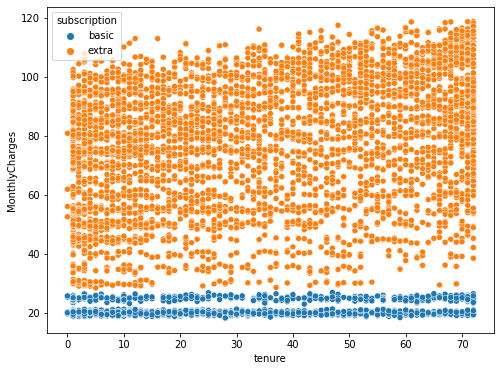

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.scatterplot(x = 'tenure', y = 'MonthlyCharges', hue = 'subscription', data = df);

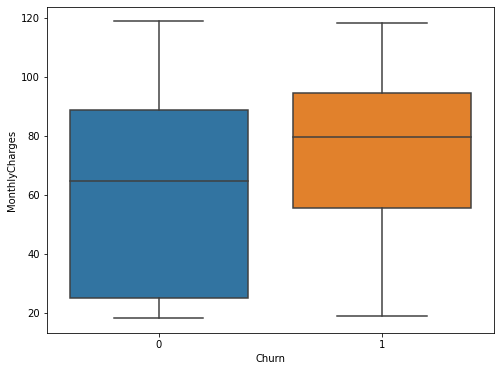

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df);

#### We need to turn the churn column into 0 (not churned) and 1 (churned)

In [ ]:
df["Churn"].value_counts() ## we will probably have to balance the dataset: either by subsampling clients who did not Churn or by simulating churning clients, or both

No     4399
Yes    1587
Name: Churn, dtype: int64

In [ ]:
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

In [ ]:
df["Churn"] = df["Churn"].astype('int')
df["Churn"].value_counts()

0    4399
1    1587
Name: Churn, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   object 
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


## Data split

In [ ]:
X = df.drop(columns = ["Churn"])
y = df["Churn"]
X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 17)

## Initial analysis without the "subscription" variable

In [ ]:
X_train = X_train_tot.drop(columns = ["subscription"])
y_train = y_train_tot
X_test = X_test_tot.drop(columns = ["subscription"])
y_test = y_test_tot

## Categorical and numerical features

In [ ]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features, numeric_features

(['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['tenure', 'MonthlyCharges', 'TotalCharges'])

In [ ]:
for cat_f in categorical_features:
  print(X_train[cat_f].unique())

['Female' 'Male']
['Y' 'S']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No phone service' 'No']
['Fiber optic' 'DSL' 'No']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['Two year' 'Month-to-month' 'One year']
['Yes' 'No']
['Credit card (automatic)' 'Electronic check' 'Bank transfer (automatic)'
 'Mailed check']


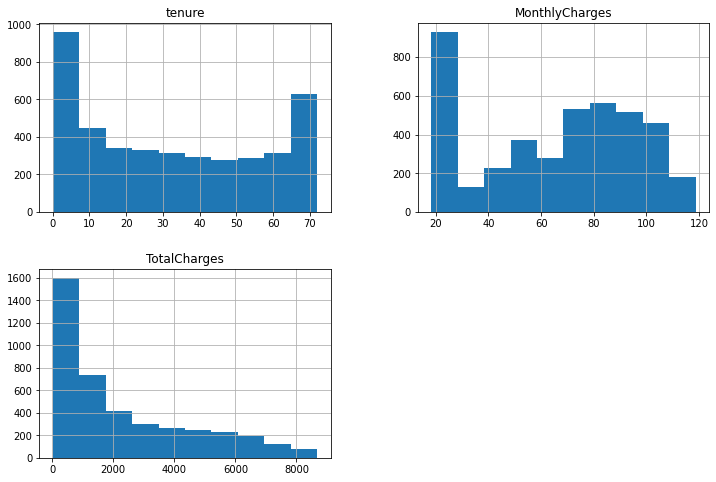

In [ ]:
X_train[numeric_features].hist(figsize = (12, 8));

In [ ]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscription
0,Male,Y,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,basic
1,Female,Y,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,extra
2,Female,S,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,extra
3,Male,Y,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,extra
4,Male,Y,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,extra


In [ ]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: Churn, dtype: int64

In [ ]:
y_test.value_counts()

0    1332
1     464
Name: Churn, dtype: int64

## Pipelines for transforming categorical and numerical features

In [ ]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available')), ## this puts "not available" to all the missing values af categorical variables
                                          ("onehot", OneHotEncoder(handle_unknown="ignore")) ## this creates dummy variables for each categorical variable
                                          ])
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)), ## this fills the NA values using K nearest neighbor
                                      ("scaler", StandardScaler()) ## this scales variables
                                      ])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])
# preprocessor

## Models pipelines

In [ ]:
lr = LogisticRegression()
pipeline_lr = Pipeline(steps=[("pre_process", preprocessor), 
                              ("model", lr)])
# pipeline_lr

In [ ]:
knn = KNeighborsClassifier()
pipeline_knn = Pipeline([("pre_process", preprocessor),
                         ("model", knn)])
# pipeline_knn

In [ ]:
nb = BernoulliNB()
pipeline_nb = Pipeline([("pre_process", preprocessor),
                         ("model", nb)])
# pipeline_nb

In [ ]:
svc = LinearSVC()
pipeline_svc = Pipeline([("pre_process", preprocessor),
                         ("model", svc)])
# pipeline_svc

In [ ]:
dtc = DecisionTreeClassifier()
pipeline_dtc = Pipeline([("pre_process", preprocessor),
                         ("model", dtc)])
# pipeline_dtc

In [ ]:
rf = RandomForestClassifier()
pipeline_rf = Pipeline([("pre_process", preprocessor),
                         ("model", rf)])
# pipeline_rf

In [ ]:
xgb = GradientBoostingClassifier()
pipeline_xgb = Pipeline([("pre_process", preprocessor),
                         ("model", xgb)])
# pipeline_xgb

## testing score function

In [ ]:
def scores_fun(pip):
  pip.fit(X_train, y_train)
  y_pred = pip.predict(X_test)
  class_labels = pip.named_steps['model'].classes_
  print(classification_report(y_test, y_pred))
  print(pd.DataFrame(confusion_matrix(y_test, y_pred),
              columns=class_labels, index=class_labels))
  print(f'Total predicted calls to customers: {len(y_pred[y_pred == 1])}\n')

## Default model performances

The logistic regression model

In [ ]:
scores_fun(pipeline_lr)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.51      0.57       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1196  136
1   227  237
Total predicted calls to customers: 373



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
scores_fun(pipeline_knn)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1332
           1       0.54      0.49      0.51       464

    accuracy                           0.76      1796
   macro avg       0.68      0.67      0.68      1796
weighted avg       0.75      0.76      0.76      1796

      0    1
0  1135  197
1   236  228
Total predicted calls to customers: 425



In [ ]:
scores_fun(pipeline_nb) ## wow!

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  949  383
1  108  356
Total predicted calls to customers: 739



In [ ]:
scores_fun(pipeline_svc)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.63      0.50      0.56       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.71      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1197  135
1   230  234
Total predicted calls to customers: 369



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
scores_fun(pipeline_dtc)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1332
           1       0.48      0.49      0.48       464

    accuracy                           0.73      1796
   macro avg       0.65      0.65      0.65      1796
weighted avg       0.73      0.73      0.73      1796

      0    1
0  1086  246
1   238  226
Total predicted calls to customers: 472



In [ ]:
scores_fun(pipeline_rf)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1332
           1       0.58      0.44      0.50       464

    accuracy                           0.77      1796
   macro avg       0.70      0.66      0.67      1796
weighted avg       0.76      0.77      0.76      1796

      0    1
0  1182  150
1   261  203
Total predicted calls to customers: 353



In [ ]:
scores_fun(pipeline_xgb)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.49      0.55       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.71      1796
weighted avg       0.78      0.80      0.79      1796

      0    1
0  1201  131
1   236  228
Total predicted calls to customers: 359



## hyperparameter tuning

#### random and grid search functions

In [ ]:
def random_search_opt(pipeline, param, score):
  rand_obj = RandomizedSearchCV(pipeline, param, scoring=score, n_iter=10, cv=5, n_jobs=-1)
  rand_obj = rand_obj.fit(X_train, y_train)
  print(f'Best %s-score: {rand_obj.best_score_:.3f}\n' % score)
  print(f'Best parameter set: {rand_obj.best_params_}\n')
  # Set the clf to the best combination of parameters
  best_clf = rand_obj.best_estimator_
  ## model performances and the testing set
  print("testing set scores")
  print(scores_fun(best_clf))

def grid_search_opt(pipeline, param, score):
  rand_obj = GridSearchCV(pipeline, param, scoring=score, cv=5, n_jobs=-1)
  rand_obj = rand_obj.fit(X_train, y_train)
  print(f'Best %s-score: {rand_obj.best_score_:.3f}\n' % score)
  print(f'Best parameter set: {rand_obj.best_params_}\n')
  # Set the clf to the best combination of parameters
  best_clf = rand_obj.best_estimator_
  ## model performances and the testing set
  print("testing set scores")
  print(scores_fun(best_clf))

#### logistic regression

In [ ]:
## dictionary for logistic regression hyperparameters
parameters_lr = {   
        'model__solver': ['saga', 'liblinear'], ## need to put model__ to call the oblect model in the pipeline before setting the parameters
        'model__penalty': ['none', 'l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__class_weight': ["None", "balanced"],
        'model__random_state': [42]
    }

In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best recall-score: 0.811

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'l1', 'model__class_weight': 'balanced', 'model__C': 100}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1332
           1       0.50      0.78      0.61       464

    accuracy                           0.74      1796
   macro avg       0.70      0.76      0.71      1796
weighted avg       0.80      0.74      0.76      1796

     0    1
0  974  358
1  101  363
Total predicted calls to customers: 721

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "precision")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best precision-score: 0.655

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'none', 'model__class_weight': 'None', 'model__C': 1}

testing set scores
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.51      0.57       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1196  136
1   227  237
Total predicted calls to customers: 373

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "f1")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best f1-score: 0.631

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'none', 'model__class_weight': 'balanced', 'model__C': 0.01}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1332
           1       0.50      0.78      0.61       464

    accuracy                           0.74      1796
   macro avg       0.70      0.76      0.71      1796
weighted avg       0.80      0.74      0.76      1796

     0    1
0  974  358
1  101  363
Total predicted calls to customers: 721

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Decision trees

In [ ]:
parameters_dtc = {   
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [5, 8, 10],
        'model__max_features': ['sqrt', 'log2'],
        'model__class_weight': ["None", "balanced"],
        'model__random_state': [42]
    }

In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "recall")

Best recall-score: 0.829

Best parameter set: {'model__random_state': 42, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1332
           1       0.44      0.81      0.57       464

    accuracy                           0.68      1796
   macro avg       0.67      0.72      0.66      1796
weighted avg       0.79      0.68      0.70      1796

     0    1
0  854  478
1   89  375
Total predicted calls to customers: 853

None


In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "precision")

Best precision-score: 0.493

Best parameter set: {'model__random_state': 42, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      1332
           1       0.45      0.73      0.56       464

    accuracy                           0.70      1796
   macro avg       0.67      0.71      0.67      1796
weighted avg       0.77      0.70      0.72      1796

     0    1
0  919  413
1  123  341
Total predicted calls to customers: 754

None


In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "f1")

Best f1-score: 0.594

Best parameter set: {'model__random_state': 42, 'model__max_features': 'sqrt', 'model__max_depth': 8, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1332
           1       0.48      0.78      0.59       464

    accuracy                           0.72      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.72      0.74      1796

     0    1
0  935  397
1  104  360
Total predicted calls to customers: 757

None


#### Support vector machines

In [ ]:
parameters_svc = {
    'model__penalty': ['none', 'l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__class_weight': ["None", "balanced"],
    'model__random_state': [42]
}

In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best recall-score: 0.816

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 10}

testing set scores
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1332
           1       0.53      0.72      0.61       464

    accuracy                           0.76      1796
   macro avg       0.71      0.75      0.72      1796
weighted avg       0.79      0.76      0.77      1796

      0    1
0  1030  302
1   129  335
Total predicted calls to customers: 637

None


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "precision")

Best precision-score: 0.512

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.01}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1332
           1       0.50      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  970  362
1  107  357
Total predicted calls to customers: 719

None


In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "f1")

Best f1-score: 0.625

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.01}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1332
           1       0.50      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  970  362
1  107  357
Total predicted calls to customers: 719

None


#### Naive Bayes

In [ ]:
parameters_nb = {
    'model__alpha': [0, 1],
}

In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best recall-score: 0.800

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "precision")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best precision-score: 0.497

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "f1")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best f1-score: 0.613

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


#### Random forests

In [ ]:
parameters_rf = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 8, 10],
    'model__max_features': ['sqrt', 'log2'],
    'model__n_estimators': [5, 50, 100],
    'model__class_weight': ["None", "balanced"],
    'model__random_state': [42]
}

In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "recall")

Best recall-score: 0.805

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1332
           1       0.49      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  966  366
1  106  358
Total predicted calls to customers: 724

None


In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "precision")

Best precision-score: 0.570

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 50, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1332
           1       0.55      0.66      0.60       464

    accuracy                           0.77      1796
   macro avg       0.71      0.74      0.72      1796
weighted avg       0.79      0.77      0.78      1796

      0    1
0  1082  250
1   158  306
Total predicted calls to customers: 556

None


In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "f1")

Best f1-score: 0.629

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 100, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1332
           1       0.49      0.77      0.60       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.70      1796
weighted avg       0.79      0.73      0.75      1796

     0    1
0  963  369
1  109  355
Total predicted calls to customers: 724

None


#### XG boost

In [ ]:
parameters_xgb = {
    'model__loss': ['deviance', 'exponential'],
    'model__criterion': ['friedman_mse', 'mse', 'mae'],
    'model__max_depth': [5, 8, 10],
    'model__max_features': ['sqrt', 'log2'],
    'model__n_estimators': [5, 50, 100],
    'model__random_state': [42]
}

In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "recall")

Best recall-score: 0.535

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 100, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__loss': 'deviance', 'model__criterion': 'friedman_mse'}

testing set scores
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.63      0.50      0.56       464

    accuracy                           0.80      1796
   macro avg       0.73      0.70      0.71      1796
weighted avg       0.78      0.80      0.79      1796

      0    1
0  1196  136
1   232  232
Total predicted calls to customers: 368

None


In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "precision")

In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "f1")

## Adding one feature informing about the type of customer subscription to possibly help predictions

The new categorical feature will seperate customers between basic subscriptions and extra option subscriptions. Given that most churn happen with extra options, I hope that this dichotomy will help predicting churn.

Now, we repeat the above analysis using this new feature in the dataset

In [ ]:
X_train = X_train_tot
y_train = y_train_tot
X_test = X_test_tot
y_test = y_test_tot

In [ ]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features, numeric_features

(['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'subscription'],
 ['tenure', 'MonthlyCharges', 'TotalCharges'])

In [ ]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscription
0,Male,Y,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,basic
1,Female,Y,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,extra
2,Female,S,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,extra
3,Male,Y,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,extra
4,Male,Y,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,extra


## Default models analyses

In [ ]:
scores_fun(pipeline_lr)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.51      0.57       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1196  136
1   227  237
Total predicted calls to customers: 373



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
scores_fun(pipeline_dtc)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1332
           1       0.48      0.50      0.49       464

    accuracy                           0.73      1796
   macro avg       0.65      0.66      0.65      1796
weighted avg       0.74      0.73      0.73      1796

      0    1
0  1081  251
1   231  233
Total predicted calls to customers: 484



In [ ]:
scores_fun(pipeline_knn)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1332
           1       0.54      0.49      0.51       464

    accuracy                           0.76      1796
   macro avg       0.68      0.67      0.68      1796
weighted avg       0.75      0.76      0.76      1796

      0    1
0  1135  197
1   236  228
Total predicted calls to customers: 425



In [ ]:
scores_fun(pipeline_nb)

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  949  383
1  108  356
Total predicted calls to customers: 739



In [ ]:
scores_fun(pipeline_rf)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1332
           1       0.60      0.44      0.50       464

    accuracy                           0.78      1796
   macro avg       0.71      0.67      0.68      1796
weighted avg       0.76      0.78      0.77      1796

      0    1
0  1195  137
1   261  203
Total predicted calls to customers: 340



In [ ]:
scores_fun(pipeline_xgb)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.49      0.55       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.71      1796
weighted avg       0.78      0.80      0.79      1796

      0    1
0  1201  131
1   236  228
Total predicted calls to customers: 359



## Hyperparameter optimization

#### Logistic regression

In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best recall-score: 0.811

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'none', 'model__class_weight': 'balanced', 'model__C': 10}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1332
           1       0.50      0.78      0.61       464

    accuracy                           0.74      1796
   macro avg       0.70      0.76      0.71      1796
weighted avg       0.80      0.74      0.76      1796

     0    1
0  974  358
1  101  363
Total predicted calls to customers: 721

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "precision")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best precision-score: 0.656

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'l1', 'model__class_weight': 'None', 'model__C': 10}

testing set scores
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1332
           1       0.64      0.51      0.57       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1196  136
1   227  237
Total predicted calls to customers: 373

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_lr, parameters_lr, "f1")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best f1-score: 0.631

Best parameter set: {'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'none', 'model__class_weight': 'balanced', 'model__C': 10}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1332
           1       0.50      0.78      0.61       464

    accuracy                           0.74      1796
   macro avg       0.70      0.76      0.71      1796
weighted avg       0.80      0.74      0.76      1796

     0    1
0  974  358
1  101  363
Total predicted calls to customers: 721

None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Decision trees

In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "recall")

Best recall-score: 0.829

Best parameter set: {'model__random_state': 42, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1332
           1       0.44      0.81      0.57       464

    accuracy                           0.68      1796
   macro avg       0.67      0.72      0.66      1796
weighted avg       0.79      0.68      0.70      1796

     0    1
0  854  478
1   89  375
Total predicted calls to customers: 853

None


In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "precision")

Best precision-score: 0.483

Best parameter set: {'model__random_state': 42, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1332
           1       0.47      0.68      0.55       464

    accuracy                           0.72      1796
   macro avg       0.67      0.71      0.67      1796
weighted avg       0.76      0.72      0.73      1796

     0    1
0  973  359
1  148  316
Total predicted calls to customers: 675

None


In [ ]:
random_search_opt(pipeline_dtc, parameters_dtc, "f1")

Best f1-score: 0.596

Best parameter set: {'model__random_state': 42, 'model__max_features': 'log2', 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      1332
           1       0.44      0.77      0.56       464

    accuracy                           0.69      1796
   macro avg       0.66      0.71      0.66      1796
weighted avg       0.77      0.69      0.71      1796

     0    1
0  879  453
1  109  355
Total predicted calls to customers: 808

None


#### Support vector machine

In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best recall-score: 0.816

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 1}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1332
           1       0.49      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  966  366
1  107  357
Total predicted calls to customers: 723

None


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "precision")

Best precision-score: 0.512

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.01}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1332
           1       0.50      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  970  362
1  107  357
Total predicted calls to customers: 719

None


In [ ]:
random_search_opt(pipeline_svc, parameters_svc, "f1")

Best f1-score: 0.629

Best parameter set: {'model__random_state': 42, 'model__penalty': 'l2', 'model__class_weight': 'balanced', 'model__C': 0.1}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1332
           1       0.50      0.77      0.60       464

    accuracy                           0.74      1796
   macro avg       0.70      0.75      0.71      1796
weighted avg       0.80      0.74      0.75      1796

     0    1
0  970  362
1  106  358
Total predicted calls to customers: 720

None


#### Naive Bayes

In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "recall")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best recall-score: 0.800

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "precision")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best precision-score: 0.497

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
random_search_opt(pipeline_nb, parameters_nb, "f1")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best f1-score: 0.613

Best parameter set: {'model__alpha': 0}

testing set scores
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1332
           1       0.48      0.77      0.59       464

    accuracy                           0.73      1796
   macro avg       0.69      0.74      0.69      1796
weighted avg       0.79      0.73      0.74      1796

     0    1
0  950  382
1  108  356
Total predicted calls to customers: 738

None


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


#### Random forests

In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "recall")

Best recall-score: 0.810

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 5, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__criterion': 'entropy', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1332
           1       0.49      0.75      0.60       464

    accuracy                           0.74      1796
   macro avg       0.69      0.74      0.70      1796
weighted avg       0.79      0.74      0.75      1796

     0    1
0  972  360
1  115  349
Total predicted calls to customers: 709

None


In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "precision")

Best precision-score: 0.573

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 50, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1332
           1       0.55      0.66      0.60       464

    accuracy                           0.77      1796
   macro avg       0.71      0.73      0.72      1796
weighted avg       0.79      0.77      0.78      1796

      0    1
0  1077  255
1   158  306
Total predicted calls to customers: 561

None


In [ ]:
random_search_opt(pipeline_rf, parameters_rf, "f1")

Best f1-score: 0.636

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 50, 'model__max_features': 'log2', 'model__max_depth': 8, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}

testing set scores
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1332
           1       0.53      0.73      0.61       464

    accuracy                           0.76      1796
   macro avg       0.71      0.75      0.72      1796
weighted avg       0.80      0.76      0.77      1796

      0    1
0  1030  302
1   126  338
Total predicted calls to customers: 640

None


#### XG boost

In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "recall")

Best recall-score: 0.526

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 50, 'model__max_features': 'log2', 'model__max_depth': 8, 'model__loss': 'deviance', 'model__criterion': 'mse'}

testing set scores
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1332
           1       0.61      0.48      0.54       464

    accuracy                           0.79      1796
   macro avg       0.72      0.69      0.70      1796
weighted avg       0.77      0.79      0.78      1796

      0    1
0  1187  145
1   239  225
Total predicted calls to customers: 370

None


In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "precision")

Best precision-score: 0.818

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 5, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__loss': 'deviance', 'model__criterion': 'friedman_mse'}

testing set scores
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1332
           1       0.80      0.08      0.14       464

    accuracy                           0.76      1796
   macro avg       0.78      0.53      0.50      1796
weighted avg       0.77      0.76      0.67      1796

      0   1
0  1323   9
1   429  35
Total predicted calls to customers: 44

None


In [ ]:
random_search_opt(pipeline_xgb, parameters_xgb, "f1")

Best f1-score: 0.582

Best parameter set: {'model__random_state': 42, 'model__n_estimators': 50, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__loss': 'deviance', 'model__criterion': 'mse'}

testing set scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1332
           1       0.65      0.50      0.56       464

    accuracy                           0.80      1796
   macro avg       0.74      0.70      0.72      1796
weighted avg       0.79      0.80      0.79      1796

      0    1
0  1208  124
1   233  231
Total predicted calls to customers: 355

None


## Feature importance

The model maximizing recall is a decision tree model predicting correctly 80% of churning customers. However, it is not a very precise model. About 66% of customers predicted to churn are actually not churning. Using this model for prediction would therefore lead to a large campaign of calls to customers by the marketing team.

To avoid large marketing campaigns, we may want to maximizing precision instead. The model maximizing precision is an XG boost model which fails to reject non churning customers only 20% of the time. This means that when a customer is predicted to churn, we can be quite sure that it will actually churn. However, only 8% of churning customers are correctly detected by the algorithm, making it a pretty bad model overall.

To optimize precision, it might be worth it using a logistic regression model instead, which leads to a 65% precision and a 50% recall. An alternative would be a random forest model leading to 57% precision and 66% recall. Under these models, the number of customers to be targeted by the marketing campaigns would be 373 and 561 respectively

In [ ]:
best_recall_model = DecisionTreeClassifier(max_depth=5, max_features='log2', class_weight='balanced', criterion='entropy', random_state=42)
pipeline_best_recall_model = Pipeline([("pre_process", preprocessor),
                         ("model", best_recall_model)])

In [ ]:
X_train['TotalCharges'][np.isnan(X_train['TotalCharges']) == True]

5695   NaN
634    NaN
3255   NaN
2771   NaN
356    NaN
Name: TotalCharges, dtype: float64

In [ ]:
imputer = KNNImputer(n_neighbors=5)
tot_charges = np.array(X_train['TotalCharges']).reshape(-1, 1)
tot_charges_nonan = imputer.fit_transform(tot_charges)
tot_charges_nonan[:5]

array([[8065.65],
       [  82.15],
       [ 156.1 ],
       [  49.95],
       [2807.65]])

In [ ]:
tot_charges_test = np.array(X_test['TotalCharges']).reshape(-1, 1)
tot_charges_test_nonan = imputer.transform(tot_charges_test)
tot_charges_test_nonan[:5]

array([[6049.5 ],
       [ 926.  ],
       [4753.85],
       [ 706.6 ],
       [5498.2 ]])

In [ ]:
encoded = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_train_dummies = X_train[numeric_features].join(encoded)
X_train_dummies.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Y,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,subscription_extra
5916,72,110.65,8065.65,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1
2406,3,30.40,82.15,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2151,4,38.55,156.10,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
844,1,49.95,49.95,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5317,31,89.45,2807.65,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [ ]:
encoded = pd.get_dummies(X_test[categorical_features], drop_first=True)
X_test_dummies = X_test[numeric_features].join(encoded)
X_test_dummies.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Y,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,subscription_extra
2639,54,114.65,6049.50,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1
2102,44,20.60,926.00,1,1,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
3855,46,100.25,4753.85,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1
3813,9,74.75,706.60,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2213,70,77.30,5498.20,1,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1


In [ ]:
X_train_dummies['TotalCharges'] = tot_charges_nonan
X_train_dummies.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Y,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,subscription_extra
5916,72,110.65,8065.65,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1
2406,3,30.40,82.15,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2151,4,38.55,156.10,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
844,1,49.95,49.95,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
5317,31,89.45,2807.65,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [ ]:
X_test_dummies['TotalCharges'] = tot_charges_test_nonan
X_test_dummies.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Y,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,subscription_extra
2639,54,114.65,6049.50,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,1
2102,44,20.60,926.00,1,1,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
3855,46,100.25,4753.85,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1
3813,9,74.75,706.60,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2213,70,77.30,5498.20,1,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1


In [ ]:
X_train_dummies['TotalCharges'][np.isnan(X_train_dummies['TotalCharges']) == True]

Series([], Name: TotalCharges, dtype: float64)

In [ ]:
X_test_dummies['TotalCharges'][np.isnan(X_test_dummies['TotalCharges']) == True]

Series([], Name: TotalCharges, dtype: float64)

In [ ]:
best_recall_model.fit(X_train_dummies, y_train)
explainer = shap.KernelExplainer(best_recall_model.predict, data=shap.kmeans(X_train_dummies, 100))
shap_values = explainer.shap_values(X_test_dummies)

  0%|          | 0/1796 [00:00<?, ?it/s]

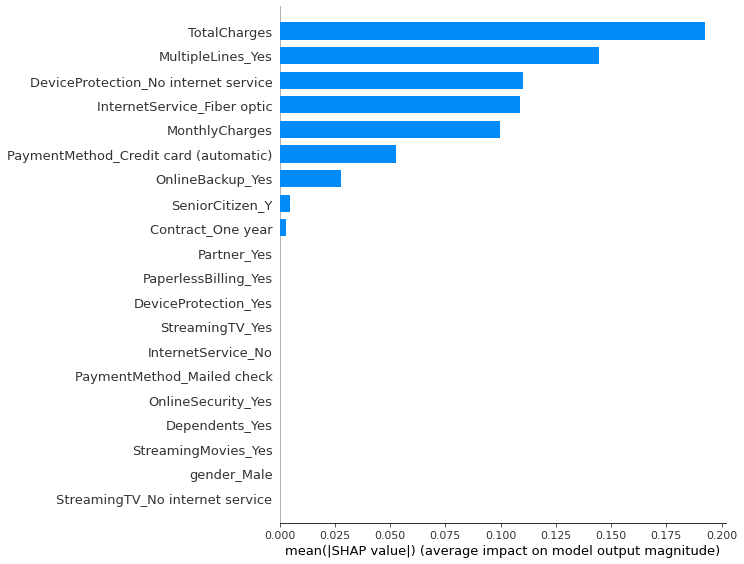

In [ ]:
shap.summary_plot(shap_values, X_test_dummies, plot_type='bar')

Now we can try to run the model without the features that have no effects

In [ ]:
X_train_reduced = X_train_dummies.drop(columns = ["Partner_Yes", "PaperlessBilling_Yes", "DeviceProtection_Yes", "StreamingTV_Yes", "InternetService_No", 
                                                  "PaymentMethod_Mailed check", "OnlineSecurity_Yes", "Dependents_Yes", "StreamingMovies_Yes", "gender_Male"])

#### The shap analysis for logistic regressions

Optimizing recall

In [ ]:
best_recall_model = LogisticRegression(solver="saga", penalty='none', class_weight='balanced', C=10, random_state=42)

In [ ]:
best_recall_model.fit(X_train_dummies, y_train)
explainer = shap.KernelExplainer(best_recall_model.predict, data=shap.kmeans(X_train_dummies, 50))
shap_values = explainer.shap_values(X_test_dummies)

Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge


  0%|          | 0/1796 [00:00<?, ?it/s]

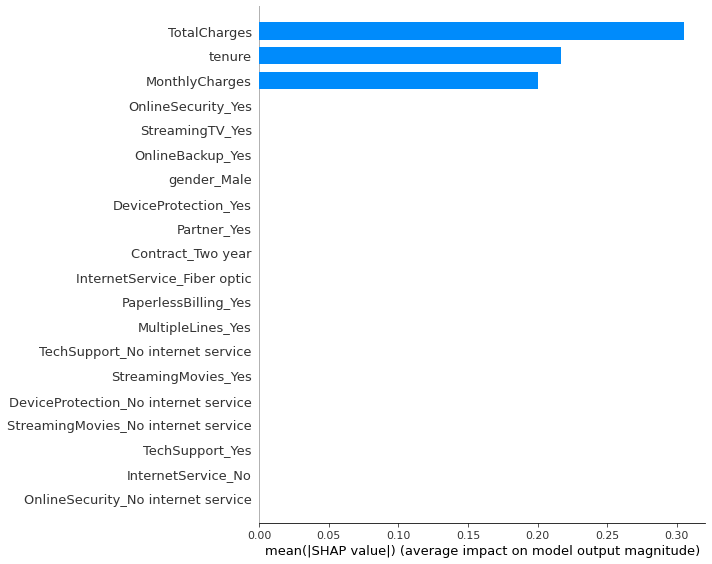

In [ ]:
shap.summary_plot(shap_values, X_test_dummies, plot_type='bar')

Optimizing precision

In [ ]:
best_recall_model = LogisticRegression(solver="saga", penalty='l1', class_weight='None', C=10, random_state=42)

In [ ]:
best_recall_model.fit(X_train_dummies, y_train)
explainer = shap.KernelExplainer(best_recall_model.predict, data=shap.kmeans(X_train_dummies, 50))
shap_values = explainer.shap_values(X_test_dummies)

The max_iter was reached which means the coef_ did not converge


  0%|          | 0/1796 [00:00<?, ?it/s]

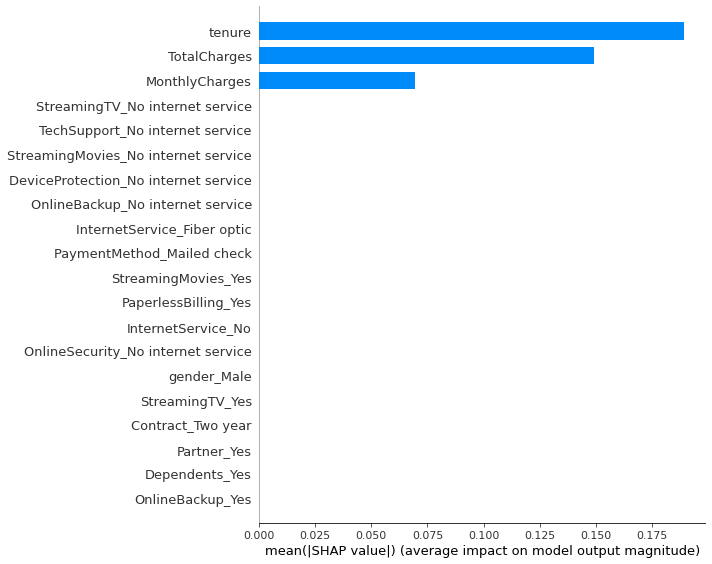

In [ ]:
shap.summary_plot(shap_values, X_test_dummies, plot_type='bar')

We can try re-runing the model with only the 3 important features 

In [ ]:
X_train_reduced = X_train_dummies[["tenure", "TotalCharges", "MonthlyCharges"]]
X_test_reduced = X_test_dummies[["tenure", "TotalCharges", "MonthlyCharges"]]

In [ ]:
best_recall_model.fit(X_train_reduced, y_train)
y_pred = best_recall_model.predict(X_test_reduced)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1332
           1       0.52      0.48      0.50       464

    accuracy                           0.75      1796
   macro avg       0.67      0.67      0.67      1796
weighted avg       0.75      0.75      0.75      1796



The max_iter was reached which means the coef_ did not converge


## Graphs

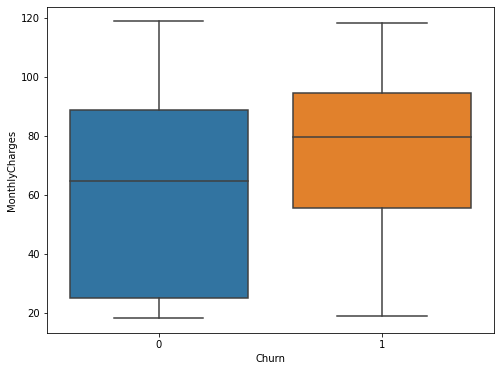

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df)

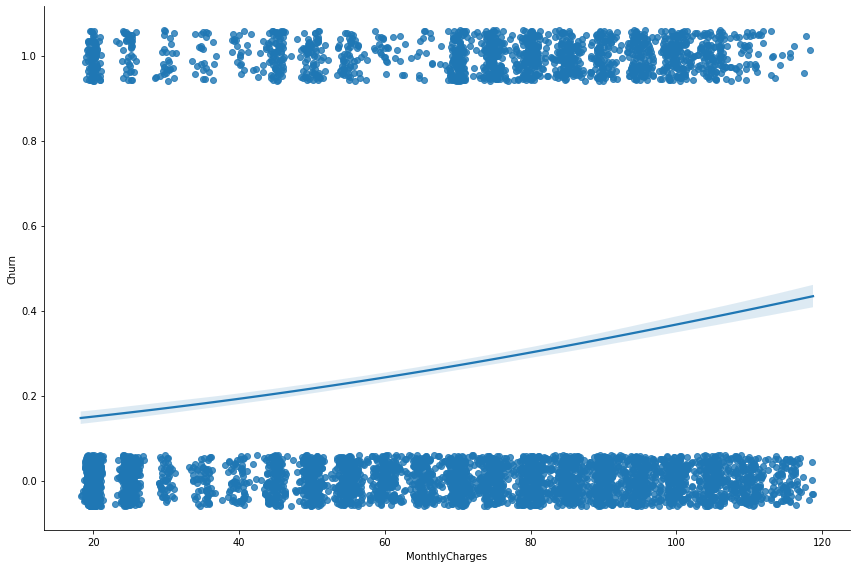

In [ ]:
sns.lmplot(x='MonthlyCharges', y='Churn', data=df,
           logistic=True, y_jitter=.06, height=8, aspect=1.5);

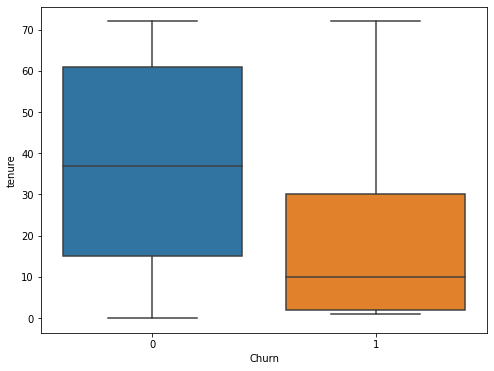

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.boxplot(x = 'Churn', y = 'tenure', data = df);

In [ ]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,subscription
0,Male,Y,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,0,basic
1,Female,Y,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,0,extra
2,Female,S,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,1,extra
3,Male,Y,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,0,extra
4,Male,Y,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,0,extra


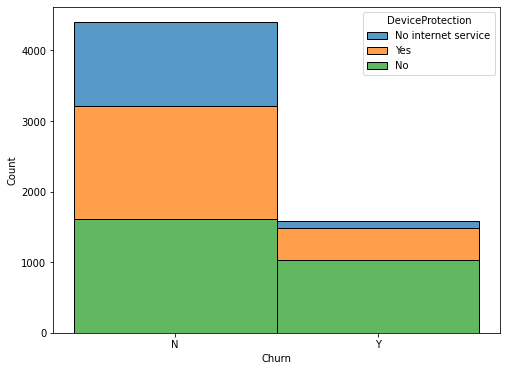

In [ ]:
df["ChurnYN"] = df["Churn"].apply(lambda x: 'Y' if x == 1 else 'N')
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(binwidth=0.5, x="ChurnYN", hue="DeviceProtection", data=df, stat="count", multiple="stack")
ax.set_xlabel("Churn");

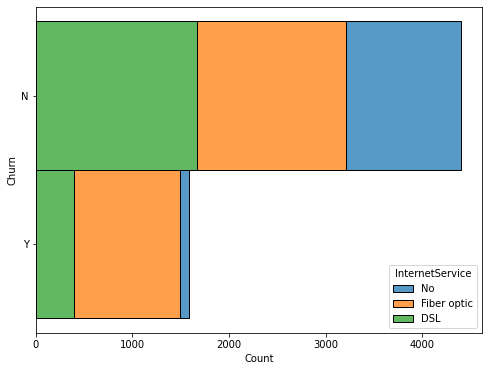

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(binwidth=0.5, y="ChurnYN", hue="InternetService", data=df, stat="count", multiple="stack")
ax.set_ylabel("Churn");

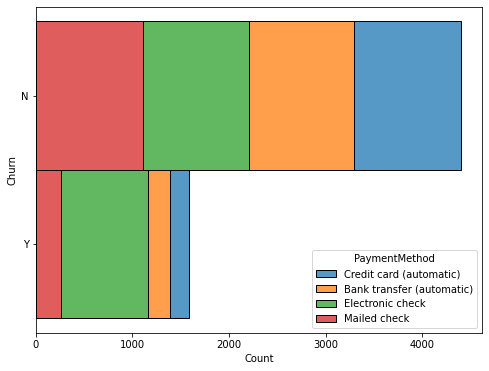

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(binwidth=0.5, y="ChurnYN", hue="PaymentMethod", data=df, stat="count", multiple="stack")
ax.set_ylabel("Churn");

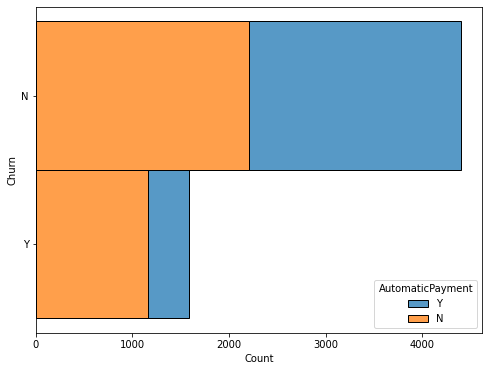

In [ ]:
df["AutomaticPayment"] = df['PaymentMethod'].apply(lambda x: "Y" if (x == "Credit card (automatic)")|(x == "Bank transfer (automatic)") else "N")
fig, ax = plt.subplots(figsize = (8, 6))
sns.histplot(binwidth=0.5, y="ChurnYN", hue="AutomaticPayment", data=df, stat="count", multiple="stack")
ax.set_ylabel("Churn");

Data cleaning / exploration - Matthias, Lingxuan, Ruben

Balance sample?

Baseline models - Manual
Baseline models - AutoML

Feature_selection - Multicolinearity

Outliers

Baseline models

Tuning models / hyperparameter

Feture_selection / Shap?

